# LLM-as-Judge Analysis Notebook

This notebook analyzes the quality of generated answers using an LLM judge model.

## Configuration
- Automatically uses the **latest wandb run** by default
- Can be configured to use a specific run (see cell 1)
- Uses **validation_generations.pkl** by default (can be changed to train_generations.pkl)
- Judge model: **Llama-3-8B-Instruct** (configurable in cell 5)

## How to Use
1. Run all cells in order
2. The notebook will automatically find the latest run
3. To use a specific run, modify cell 1 to specify the run name
4. To change the judge model, modify `judge_model_name` in cell 5


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import pickle
import pickle
import math
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import re
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Configuration: Set the wandb run directory or use the latest run
import os
import glob
from pathlib import Path

# Option 1: Use the latest run automatically
wandb_dir = "../nikos/uncertainty/wandb"
run_dirs = glob.glob(os.path.join(wandb_dir, "run-*"))
if run_dirs:
    # Sort by modification time, get the latest
    latest_run = max(run_dirs, key=os.path.getmtime)
    run_name = os.path.basename(latest_run)
    print(f"Using latest run: {run_name}")
else:
    raise ValueError("No wandb runs found!")

# Option 2: Specify a specific run (uncomment and modify if needed)
# run_name = "run-20251105_092213-5gtbq0rw"  # Example: latest run with generations

# Use validation_generations.pkl (for validation data) or train_generations.pkl (for training data)
generation_file = "validation_generations.pkl"  # Change to "train_generations.pkl" if needed
pickle_path = os.path.join(wandb_dir, run_name, "files", generation_file)

print(f"Loading generations from: {pickle_path}")
if not os.path.exists(pickle_path):
    print(f"Warning: {pickle_path} not found. Trying train_generations.pkl...")
    generation_file = "train_generations.pkl"
    pickle_path = os.path.join(wandb_dir, run_name, "files", generation_file)
    if not os.path.exists(pickle_path):
        raise FileNotFoundError(f"Neither validation_generations.pkl nor train_generations.pkl found in {run_name}")

In [9]:
df_ = pd.read_pickle(pickle_path)

In [10]:
df_

{'jp_1522--195/195_398259.txt#0_1': {'question': '"Who said ""we\'re more popular than Jesus now"", in 1966?"',
  'context': '[PAR] Beatles Albums Ranked Worst to Best [PAR] Image of[DOC] [TLE] the Beatles were more popular than JesusJohn Lennon Interview: London Evening Standard 3/4/1966 - How Does A Beatle Live? Maureen Cleave - "We\'re More popular than Jesus Now" - Beatles Interviews Database [PAR] John Lennon Interview: London Evening Standard, "More Popular Than Jesus" 3/4/1966 [PAR] QUICK MENU [PAR] ABOUT THIS INTERVIEW: [PAR] Reporter Maureen Cleave, a good friend of John Lennon\'s, wrote a personality article about him that would be published in the March 4th 1966 edition of the London Evening Standard. Cleave\'s piece was intended to present a portrait of the behind-the-scenes Lennon, and was entitled \'How Does A Beatle Live? John Lennon Lives Like This.\' The article contained a number of Lennon musings, remarks and random thoughts from a recent conversation she had with hi

In [ ]:
# Load the data
# pickle_path is already set in cell above
data = pickle.load(open(pickle_path, 'rb'))

print(f"Loaded {len(data)} examples")
print("Sample data structure:")
first_key = list(data.keys())[0]
sample = data[first_key]
print(f"Question: {sample['question'][:100]}...")
print(f"Context: {sample['context'][:100]}...")
print(f"Most likely answer: {sample['most_likely_answer']['response']}")
print(f"Reference answer: {sample['reference']['answers']['text'][0]}")
print(f"Accuracy: {sample['most_likely_answer']['accuracy']}")


Loaded 400 examples
Sample data structure:
Question: "Who said ""we're more popular than Jesus now"", in 1966?"...
Context: [PAR] Beatles Albums Ranked Worst to Best [PAR] Image of[DOC] [TLE] the Beatles were more popular th...
Most likely answer: the beatles
Reference answer: john lennon
Accuracy: 0.0


In [ ]:
# Initialize the LLM Judge
# Configure which judge model to use
# Options:
# - "meta-llama/Llama-3-8B-Instruct" (recommended for 8GB GPU)
# - "meta-llama/Llama-2-7b-chat-hf" (older model)
# - "meta-llama/Llama-3.1-70B-Instruct" (requires large GPU)
judge_model_name = "meta-llama/Llama-3-8B-Instruct"  # Change this to use a different judge

print(f"Loading judge model: {judge_model_name}")
print("This may take a few minutes...")

tokenizer = AutoTokenizer.from_pretrained(judge_model_name)
model = AutoModelForCausalLM.from_pretrained(
    judge_model_name,
    torch_dtype=torch.float16,
    device_map="auto",
)

# Set pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("Judge model loaded successfully!")


Loading judge model...


Loading checkpoint shards: 100%|██████████| 2/2 [00:14<00:00,  7.25s/it]


Judge model loaded successfully!


In [ ]:
def create_judge_prompt(question, context, answer, reference_answer, tokenizer=None):
    """
    Create a prompt for the LLM judge to evaluate answer correctness.
    Uses the tokenizer's chat template if available (for Llama-3), otherwise uses Llama-2 format.
    """
    system_message = "You are an expert judge evaluating the correctness of answers to questions."
    
    user_message = f"""Question: {question}

Context: {context[:1000]}...""" if len(context) > 1000 else f"""Question: {question}

Context: {context}

Generated Answer: {answer}

Reference Answer: {reference_answer}

Please evaluate whether the generated answer is correct compared to the reference answer. Consider:
1. Semantic equivalence (same meaning even if different wording)
2. Factual accuracy
3. Completeness of the answer

Respond with ONLY a probability score between 0.0 and 1.0, where:
- 1.0 = Completely correct
- 0.8-0.9 = Mostly correct with minor issues
- 0.6-0.7 = Partially correct
- 0.4-0.5 = Somewhat correct but with significant issues
- 0.2-0.3 = Mostly incorrect
- 0.0-0.1 = Completely incorrect

Format your response as: CORRECTNESS_PROBABILITY: [number between 0.0 and 1.0]"""
    
    # Use tokenizer's chat template if available (for Llama-3)
    if tokenizer and hasattr(tokenizer, 'apply_chat_template'):
        try:
            messages = [
                {"role": "system", "content": system_message},
                {"role": "user", "content": user_message}
            ]
            prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
            return prompt
        except:
            pass
    
    # Fallback to Llama-2 format
    prompt = f"""<s>[INST] {system_message}

{user_message} [/INST]"""
    
    return prompt

def extract_probability_from_response(response):
    """
    Extract the probability score from the model's response.
    """
    # Look for the pattern "CORRECTNESS_PROBABILITY: [number]"
    pattern = r'CORRECTNESS_PROBABILITY:\s*([0-9]*\.?[0-9]+)'
    match = re.search(pattern, response, re.IGNORECASE)
    
    if match:
        try:
            prob = float(match.group(1))
            # Ensure probability is between 0 and 1
            return max(0.0, min(1.0, prob))
        except ValueError:
            pass
    
    # Fallback: look for any number between 0 and 1 in the response
    numbers = re.findall(r'0\.\d+', response)
    if numbers:
        try:
            return float(numbers[0])
        except ValueError:
            pass
    
    # If no valid probability found, return 0.5 (neutral)
    return 0.5


In [ ]:
def judge_answer_correctness(question, context, answer, reference_answer, model, tokenizer):
    """
    Use the LLM judge to evaluate answer correctness and return a probability score.
    """
    prompt = create_judge_prompt(question, context, answer, reference_answer, tokenizer)
    
    # Tokenize the input
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=4096)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    # Generate response
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=50,
            temperature=0.1,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
    
    # Decode the response (only the new tokens, not the input)
    input_length = inputs['input_ids'].shape[1]
    response = tokenizer.decode(outputs[0][input_length:], skip_special_tokens=True)
    
    # Extract the probability from the response
    probability = extract_probability_from_response(response)
    
    return probability, response

# Test the judge function with a sample
print("Testing the judge function...")
first_key = list(data.keys())[0]
sample = data[first_key]

question = sample['question']
context = sample['context']
answer = sample['most_likely_answer']['response']
reference = sample['reference']['answers']['text'][0]

print(f"Question: {question}")
print(f"Answer: {answer}")
print(f"Reference: {reference}")

# Test the judge
prob, full_response = judge_answer_correctness(question, context, answer, reference, model, tokenizer)
print(f"Judge probability: {prob}")
print(f"Full response: {full_response}")


Testing the judge function...
Question: "Who said ""we're more popular than Jesus now"", in 1966?"
Answer: the beatles
Reference: john lennon
Judge probability: 0.8
Full response: [INST] You are an expert judge evaluating the correctness of answers to questions. 

Question: "Who said ""we're more popular than Jesus now"", in 1966?"

Context: [PAR] Beatles Albums Ranked Worst to Best [PAR] Image of[DOC] [TLE] the Beatles were more popular than JesusJohn Lennon Interview: London Evening Standard 3/4/1966 - How Does A Beatle Live? Maureen Cleave - "We're More popular than Jesus Now" - Beatles Interviews Database [PAR] John Lennon Interview: London Evening Standard, "More Popular Than Jesus" 3/4/1966 [PAR] QUICK MENU [PAR] ABOUT THIS INTERVIEW: [PAR] Reporter Maureen Cleave, a good friend of John Lennon's, wrote a personality article about him that would be published in the March 4th 1966 edition of the London Evening Standard. Cleave's piece was intended to present a portrait of the behin

In [ ]:
# Run the judge analysis on all data
print("Running LLM judge analysis on all data...")

judge_results = []
ground_truth_labels = []

# Process all examples
for i, (key, sample) in enumerate(tqdm(data.items(), total=len(data))):
    question = sample['question']
    context = sample['context']
    answer = sample['most_likely_answer']['response']
    reference = sample['reference']['answers']['text'][0]
    true_accuracy = sample['most_likely_answer']['accuracy']
    
    try:
        # Get judge probability
        judge_prob, _ = judge_answer_correctness(question, context, answer, reference, model, tokenizer)
        
        judge_results.append({
            'key': key,
            'question': question,
            'context': context[:200] + '...' if len(context) > 200 else context,
            'answer': answer,
            'reference': reference,
            'true_accuracy': true_accuracy,
            'judge_probability': judge_prob
        })
        
        ground_truth_labels.append(true_accuracy)
        
    except Exception as e:
        print(f"Error processing {key}: {e}")
        # Add default values for failed cases
        judge_results.append({
            'key': key,
            'question': question,
            'context': context[:200] + '...' if len(context) > 200 else context,
            'answer': answer,
            'reference': reference,
            'true_accuracy': true_accuracy,
            'judge_probability': 0.5  # Default neutral score
        })
        ground_truth_labels.append(true_accuracy)

print(f"Completed judge analysis on {len(judge_results)} examples")


Running LLM judge analysis on all data...


100%|██████████| 400/400 [2:24:31<00:00, 21.68s/it]   

Completed judge analysis on 400 examples


In [ ]:
# Convert results to DataFrame for analysis
df_judge = pd.DataFrame(judge_results)

print("Judge Analysis Results:")
print(f"Total examples: {len(df_judge)}")
print(f"Average judge probability: {df_judge['judge_probability'].mean():.3f}")
print(f"Average true accuracy: {df_judge['true_accuracy'].mean():.3f}")

# Calculate correlation between judge probabilities and true accuracy
correlation = df_judge['judge_probability'].corr(df_judge['true_accuracy'])
print(f"Correlation between judge probability and true accuracy: {correlation:.3f}")

# Show some examples
print("\nSample results:")
print(df_judge[['question', 'answer', 'reference', 'true_accuracy', 'judge_probability']].head(10))


Judge Analysis Results:
Total examples: 400
Average judge probability: 0.786
Average true accuracy: 0.320
Correlation between judge probability and true accuracy: 0.381

Sample results:
                                            question                answer  \
0  "Who said ""we're more popular than Jesus now"...           the beatles   
1                         A bagel is a type of what?                 bread   
2  In Wagner's opera 'Das Rheingold', what was th...              alberich   
3  Bruno, nephew of which late Formula 1 legend s...    michael schumacher   
4  In the 1971 Number One hit Ernie by Benny Hill...            mrs linley   
5  Colchester stands on which river? The river sh...             the stour   
6  The islands of Hoy, Sanday and Westray belong ...  the shetland islands   
7  What monkey is friends with the Man in the Yel...         the orangutan   
8  Which artist painted the 'Seagram Murals' whic...     willem de kooning   
9  At what Bikini Bottom restauran

ROC AUC Score: 0.720


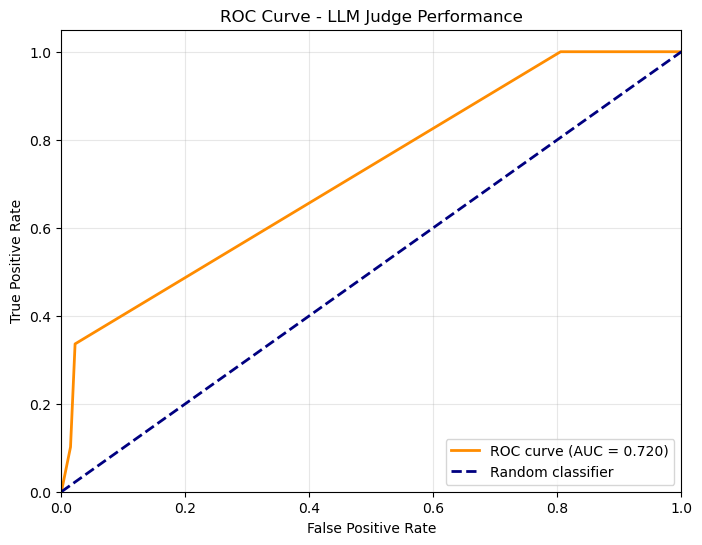

In [ ]:
# Calculate ROC AUC score
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Calculate ROC AUC
try:
    roc_auc = roc_auc_score(ground_truth_labels, df_judge['judge_probability'])
    print(f"ROC AUC Score: {roc_auc:.3f}")
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(ground_truth_labels, df_judge['judge_probability'])
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - LLM Judge Performance')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
except Exception as e:
    print(f"Error calculating ROC AUC: {e}")
    print("This might be due to all labels being the same class")


In [ ]:
# Analyze judge performance by different thresholds
print("Judge Performance Analysis:")
print("=" * 50)

# Try different probability thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for threshold in thresholds:
    # Predict correct if judge probability >= threshold
    predictions = (df_judge['judge_probability'] >= threshold).astype(int)
    
    # Calculate accuracy
    accuracy = (predictions == df_judge['true_accuracy']).mean()
    
    # Calculate precision and recall
    true_positives = ((predictions == 1) & (df_judge['true_accuracy'] == 1)).sum()
    false_positives = ((predictions == 1) & (df_judge['true_accuracy'] == 0)).sum()
    false_negatives = ((predictions == 0) & (df_judge['true_accuracy'] == 1)).sum()
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"Threshold {threshold}: Accuracy={accuracy:.3f}, Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

# Find best threshold
best_accuracy = 0
best_threshold = 0.5
for threshold in thresholds:
    predictions = (df_judge['judge_probability'] >= threshold).astype(int)
    accuracy = (predictions == df_judge['true_accuracy']).mean()
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print(f"\nBest threshold: {best_threshold} with accuracy: {best_accuracy:.3f}")


Judge Performance Analysis:
Threshold 0.3: Accuracy=0.330, Precision=0.323, Recall=1.000, F1=0.489
Threshold 0.4: Accuracy=0.330, Precision=0.323, Recall=1.000, F1=0.489
Threshold 0.5: Accuracy=0.330, Precision=0.323, Recall=1.000, F1=0.489
Threshold 0.6: Accuracy=0.330, Precision=0.323, Recall=1.000, F1=0.489
Threshold 0.7: Accuracy=0.453, Precision=0.369, Recall=1.000, F1=0.539
Threshold 0.8: Accuracy=0.453, Precision=0.369, Recall=1.000, F1=0.539
Threshold 0.9: Accuracy=0.772, Precision=0.878, Recall=0.336, F1=0.486

Best threshold: 0.9 with accuracy: 0.772


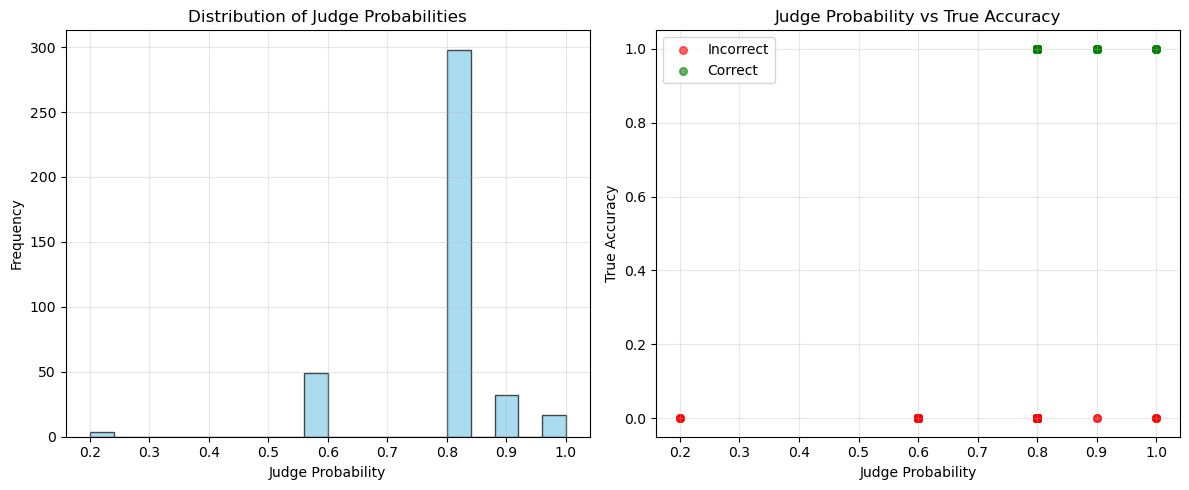

In [ ]:
# Visualize judge probability distribution
plt.figure(figsize=(12, 5))

# Plot 1: Distribution of judge probabilities
plt.subplot(1, 2, 1)
plt.hist(df_judge['judge_probability'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Judge Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Judge Probabilities')
plt.grid(True, alpha=0.3)

# Plot 2: Judge probability vs True accuracy
plt.subplot(1, 2, 2)
correct_mask = df_judge['true_accuracy'] == 1
incorrect_mask = df_judge['true_accuracy'] == 0

plt.scatter(df_judge.loc[incorrect_mask, 'judge_probability'], 
           [0] * incorrect_mask.sum(), 
           alpha=0.6, color='red', label='Incorrect', s=30)
plt.scatter(df_judge.loc[correct_mask, 'judge_probability'], 
           [1] * correct_mask.sum(), 
           alpha=0.6, color='green', label='Correct', s=30)

plt.xlabel('Judge Probability')
plt.ylabel('True Accuracy')
plt.title('Judge Probability vs True Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Save the results
import pickle
import json

# Save detailed results
results_to_save = {
    'judge_results': judge_results,
    'ground_truth_labels': ground_truth_labels,
    'correlation': correlation,
    'best_threshold': best_threshold,
    'best_accuracy': best_accuracy,
    'model_name': judge_model_name,
    'total_examples': len(judge_results)
}

# Save as pickle for later use
with open('llm_judge_results.pkl', 'wb') as f:
    pickle.dump(results_to_save, f)

# Save as JSON for human readability (without the full data)
json_results = {
    'correlation': correlation,
    'best_threshold': best_threshold,
    'best_accuracy': best_accuracy,
    'model_name': judge_model_name,
    'total_examples': len(judge_results),
    'average_judge_probability': df_judge['judge_probability'].mean(),
    'average_true_accuracy': df_judge['true_accuracy'].mean()
}

with open('llm_judge_summary.json', 'w') as f:
    json.dump(json_results, f, indent=2)

print("Results saved to:")
print("- llm_judge_results.pkl (full results)")
print("- llm_judge_summary.json (summary)")

# Display final summary
print("\n" + "="*60)
print("FINAL LLM JUDGE ANALYSIS SUMMARY")
print("="*60)
print(f"Model used: {judge_model_name}")
print(f"Total examples analyzed: {len(judge_results)}")
print(f"Average judge probability: {df_judge['judge_probability'].mean():.3f}")
print(f"Average true accuracy: {df_judge['true_accuracy'].mean():.3f}")
print(f"Correlation between judge and true accuracy: {correlation:.3f}")
print(f"Best threshold: {best_threshold}")
print(f"Best accuracy at optimal threshold: {best_accuracy:.3f}")
print("="*60)


Results saved to:
- llm_judge_results.pkl (full results)
- llm_judge_summary.json (summary)

FINAL LLM JUDGE ANALYSIS SUMMARY
Model used: meta-llama/Llama-2-7b-chat-hf
Total examples analyzed: 400
Average judge probability: 0.786
Average true accuracy: 0.320
Correlation between judge and true accuracy: 0.381
Best threshold: 0.9
Best accuracy at optimal threshold: 0.772
